In [1]:
import sys, os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import bayes_mvs as bayesest
import time

from PyEcoLib.simulator import Simulator

%matplotlib inline

In [2]:
mean_size = 1 # femtoliter
doubling_time = 18 #min
tmax = 180 #min
sample_time = 2 #min
div_steps = 10 
ncells = 1000

In [3]:
gr = np.log(2)/doubling_time 

In [4]:
sampling_time = sample_time 
rprom = 10/mean_size # RNA mean concentration (RNA/um)
pprom = 100/mean_size # prot mean concentration (RNA/um)
gammar = 5*gr # RNA Active degradation rate
kr = rprom*(gr+gammar) # RNA transcription rate
kp = pprom*gr/rprom # Protein translation rate

In [5]:
if not os.path.exists('./data/'):
    os.makedirs('./data/')
if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

In [6]:
pop = np.zeros([ncells,6])

indexes = np.int(tmax/sampling_time)
rarray = np.zeros([ncells,indexes])
parray = np.zeros([ncells,indexes])
nrarray = np.zeros([ncells,indexes])
nparray = np.zeros([ncells,indexes])

tarray = np.zeros([indexes])
szarray = np.zeros([ncells,indexes])
cellindex = 0
indexref = 0
start = time.time()
times2=[]
for cell in pop:
    if ncells > 100:
        if cellindex/ncells > indexref:
            print(str(np.int(100*cellindex/ncells))+"%")
            indexref += 0.1
    #Initialize the simulator
    sim = Simulator(ncells=1, gr = gr, sb=mean_size, steps = div_steps)
    #_______________
    #Example of a direct SSA simulation
    cell[0] = mean_size #Initial size
    cell[1] = int(mean_size*rprom/2) #Initial RNA number
    cell[2] = int(mean_size*pprom/2) #Initial Protein number
    cell[3] = (1/gr)*np.log(1-(gr/(kr*cell[0]))*np.log(np.random.rand())) #time to thenext rna creation
    cell[4] = -np.log(np.random.rand())/(gammar*cell[1]) #time to the next rna degradation
    cell[5] = -np.log(np.random.rand())/(kp*cell[1]) #time to next protein creation
    t=0
    reactions=[[0,1,0,0,0,0],[0,-1,0,0,0,0],[0,0,1,0,0,0]] #Reactions (RNA creation, RNA active degradation, Protein creation)
    nextt = 0
    index = 0
    ndiv = 0
    stp = 0
    while t<tmax: #iterating over time
        nr = cell[1]
        nprot = cell[2]
        sz = cell[0]
        tt=sim.get_next_t(0)
        tnextarr = [cell[3],cell[4],cell[5],tt]
        tau = np.min(tnextarr)
        dp = sim.get_dp(0)    
        #------------------
        sim.simulate(tmax=tau) #Simulate size dynamics for that given time
        #--------------------
        if np.argmin(tnextarr) != 3:
            cell += reactions[np.argmin(tnextarr)] #if reaction is not a division step, make the chemical reactions

        if sim.get_ndiv(0) > ndiv:
            cell[1] = np.random.binomial(nr,dp) # RNA segregated binomially
            cell[2] = np.random.binomial(nprot,dp) # Protein segregated binomially
            ndiv+=1#stp=0
        cell[0] = sim.get_sz(0)
        nr = cell[1] #Refreshing RNA number
        nprot = cell[2] #Refreshing Protein number
        sz = cell[0] #Refreshing size number
        cell[3] = (1/gr)*np.log(1-(gr/(kr*cell[0]))*np.log(np.random.rand())) #time to thenext rna creation
        cell[4] = -np.log(np.random.rand())/(gammar*cell[1]) #time to the next rna degradation
        cell[5] = -np.log(np.random.rand())/(kp*cell[1]) #time to next protein creation        
        t+=tau
        if t > nextt and index<len(tarray): #storing data
            rarray[cellindex,index] = nr/sz # RNA concentration
            parray[cellindex,index] = nprot/sz # Protein concentration
            nrarray[cellindex,index] = nr # RNA concentration
            nparray[cellindex,index] = nprot # Protein concentration
            szarray[cellindex,index] = sz # Cell size
            tarray[index] = t # Time
            index += 1
            nextt += sampling_time
    cellindex += 1 
print('It took', np.int(time.time()-start), 'seconds.')

0%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars


10%
20%
30%
40%
50%
60%
70%
80%
90%
It took 130 seconds.


In [7]:
data=pd.DataFrame(np.transpose(np.array(szarray)))
ind=0
newcol=[]
for name in data.columns:
    newcol.append("mom"+str(ind))
    ind+=1
data.columns=newcol
mnszarray=[]
cvszarray=[]
errcv2sz=[]
errmnsz=[]
for m in range(len(data)):
    szs=data.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray.append(np.mean(szs))
    errmnsz.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz.append(errv)

data['time'] = tarray
data['Mean_sz'] = mnszarray
data['Error_mean'] = errmnsz
data['sz_CV2'] = cvszarray
data['Error_CV2'] = errcv2sz

data.to_csv("./data/szsim.csv")

In [8]:
start = time.time()
sim.szdynFSP(tmax = tmax, nameFSP = "./data/sizeFSP.csv") #Obtaining trends using numerical FSP algorithm 
print('It took', np.int(time.time()-start), 'seconds.')

It took 111 seconds.


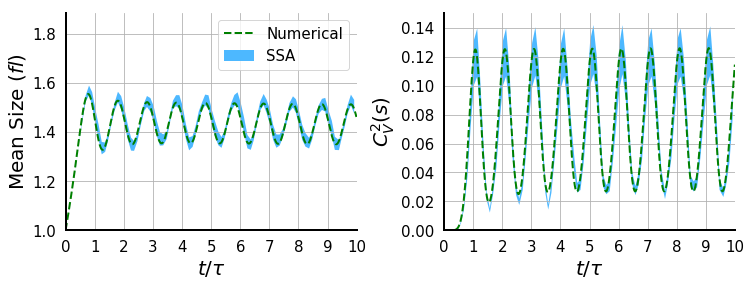

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

#ax[0].plot(tarray,mnszarray)
ax[0].fill_between(np.array(tarray)/doubling_time,np.array(mnszarray)-np.array(errmnsz),np.array(mnszarray)+np.array(errmnsz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0,label='SSA')
#ax[1].plot(tarray,cvszarray)
ax[1].fill_between(np.array(tarray)/doubling_time,np.array(cvszarray)-np.array(errcv2sz),np.array(cvszarray)+np.array(errcv2sz),
                 alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)

data=pd.read_csv("./data/sizeFSP.csv")
ax[0].plot(data.time/doubling_time,data.Meansize,ls='--',c='g',label="Numerical",lw=2)
ax[1].plot(data.time/doubling_time,data.VarSize/data.Meansize**2,ls='--',c='g',lw=2)

ax[0].set_ylabel("Mean Size ($fl$)",size=20)
ax[1].set_ylabel("$C_V^2(s)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)

ax[0].set_ylim([1,1.2*np.max(mnszarray)])
ax[1].set_ylim([0,1.2*np.max(cvszarray)])
for l in [0,1]:
    ax[l].set_xlim([0,tmax/doubling_time])
    taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
taqui=np.arange(0,0.15,step=0.02)
ax[1].set_yticks(np.array(taqui))
ax[0].legend(fontsize=15)
plt.savefig('./figures/size_statistics.eps',bbox_inches='tight')
plt.savefig('./figures/size_statistics.svg',bbox_inches='tight')
plt.savefig('./figures/size_statistics.png',bbox_inches='tight')

In [10]:
data=pd.DataFrame(np.transpose(np.array(rarray)))
ind=0
newcol=[]
for name in data.columns:
    newcol.append("mom"+str(ind))
    ind+=1
data.columns=newcol
mnrnaarray=[]
cvrnaarray=[]
errcv2rna=[]
errmnrna=[]
for m in range(len(data)):
    rnas=data.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(rnas,alpha=0.95)
    mnrnaarray.append(mean_cntr[0])
    errmnrna.append(mean_cntr[1][1]-mean_cntr[0])
    cvrnaarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2rna.append(errv)

data['time'] = tarray
data['Mean_RNA'] = mnrnaarray
data['Error_mean'] = errmnrna
data['RNA_CV2'] = cvrnaarray
data['Error_CV2'] = errcv2rna
data.to_csv("./data/cRNAsim.csv")

In [11]:
data=pd.DataFrame(np.transpose(np.array(nrarray)))
ind=0
newcol=[]
for name in data.columns:
    newcol.append("mom"+str(ind))
    ind+=1
data.columns=newcol
mnrnanarray=[]
cvrnanarray=[]
errcv2nrna=[]
errmnnrna=[]
for m in range(len(data)):
    rnas=data.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(rnas,alpha=0.95)
    mnrnanarray.append(mean_cntr[0])
    errmnnrna.append(mean_cntr[1][1]-mean_cntr[0])
    cvrnanarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2nrna.append(errv)

data['time'] = tarray
data['Mean_RNA'] = mnrnanarray
data['Error_mean'] = errmnnrna
data['RNA_CV2'] = cvrnanarray
data['Error_CV2'] = errcv2nrna
data.to_csv("./data/nRNAsim.csv")

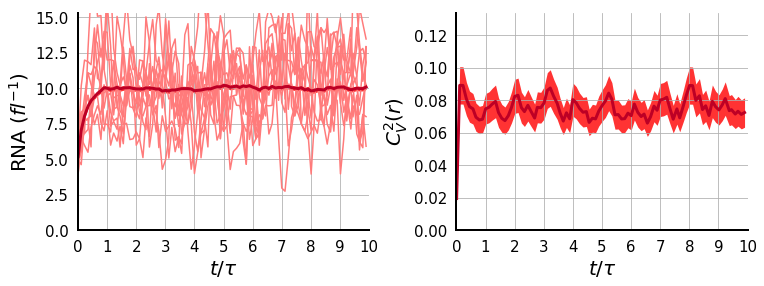

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

data=pd.read_csv("./data/cRNAsim.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:10]:
    ax[0].plot(tt/doubling_time,data[column],c="#FF7B7B",label='_nolegend_')

ax[0].plot(np.array(tarray)/doubling_time,mnrnaarray,c="#BD0025",lw=3)
ax[0].fill_between(np.array(tarray)/doubling_time,np.array(mnrnaarray)-np.array(errmnrna),np.array(mnrnaarray)+np.array(errmnrna),
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[1].plot(np.array(tarray)/doubling_time,cvrnaarray,c="#BD0025",lw=3)
ax[1].fill_between(np.array(tarray)/doubling_time,np.array(cvrnaarray)-np.array(errcv2rna),np.array(cvrnaarray)+np.array(errcv2rna),
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)


ax[0].set_ylabel("RNA ($fl^{-1}$)",size=20)
ax[1].set_ylabel("$C_V^2(r)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
ax[0].set_ylim([0,1.5*np.max(mnrnaarray)])
ax[1].set_ylim([0,1.5*np.max(cvrnaarray)])
for l in [0,1]:
    ax[l].set_xlim([0,tmax/doubling_time])
    taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
taqui=np.arange(0,1.5*np.max(cvrnaarray),step=np.round(.2*np.max(cvrnaarray),2))
ax[1].set_yticks(np.array(taqui))

plt.savefig('./figures/crna_statistics.svg',bbox_inches='tight')
plt.savefig('./figures/crna_statistics.png',bbox_inches='tight')

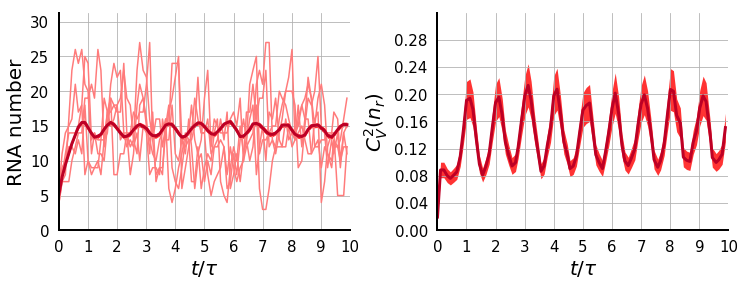

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

data=pd.read_csv("./data/nRNAsim.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:5]:
    ax[0].plot(tt/doubling_time,data[column],c="#FF7B7B",label='_nolegend_')

data=pd.read_csv("./data/nRNAsim.csv")

ax[0].plot(data.time/doubling_time,data.Mean_RNA,c="#BD0025",lw=3)
ax[0].fill_between(data.time/doubling_time,data.Mean_RNA-data.Error_mean,data.Mean_RNA+data.Error_mean,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[1].plot(data.time/doubling_time,data.RNA_CV2,c="#BD0025",lw=3)
ax[1].fill_between(data.time/doubling_time,data.RNA_CV2-data.Error_CV2,data.RNA_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)

ax[0].set_ylabel("RNA number",size=20)
ax[1].set_ylabel("$C_V^2(n_r)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
ax[0].set_ylim([0,2*np.max(data.Mean_RNA)])
ax[1].set_ylim([0,1.5*np.max(data.RNA_CV2)])
for l in [0,1]:
    ax[l].set_xlim([0,tmax/doubling_time])
    taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
taqui=np.arange(0,1.5*np.max(data.RNA_CV2),step=np.round(.2*np.max(data.RNA_CV2),2))
ax[1].set_yticks(np.array(taqui))
plt.savefig('./figures/nrna_statistics.svg',bbox_inches='tight')
plt.savefig('./figures/nrna_statistics.png',bbox_inches='tight')

In [14]:
data=pd.DataFrame(np.transpose(np.array(parray)))
ind=0
newcol=[]
for name in data.columns:
    newcol.append("mom"+str(ind))
    ind+=1
data.columns=newcol
mnprotarray=[]
cvprotarray=[]
errcv2prot=[]
errmnprot=[]
for m in range(len(data)):
    rnas=data.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(rnas,alpha=0.95)
    mnprotarray.append(mean_cntr[0])
    errmnprot.append(mean_cntr[1][1]-mean_cntr[0])
    cvprotarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2prot.append(errv)
data['time'] = tarray
data['Mean_prot'] = mnprotarray
data['Error_mean'] = errmnprot
data['prot_CV2'] = cvprotarray
data['Error_CV2'] = errcv2prot
data.to_csv("./data/prot_stat.csv")


In [15]:
data=pd.DataFrame(np.transpose(np.array(nparray)))
ind=0
newcol=[]
for name in data.columns:
    newcol.append("mom"+str(ind))
    ind+=1
data.columns=newcol
mnprotarray=[]
cvprotarray=[]
errcv2prot=[]
errmnprot=[]
for m in range(len(data)):
    rnas=data.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(rnas,alpha=0.95)
    mnprotarray.append(mean_cntr[0])
    errmnprot.append(mean_cntr[1][1]-mean_cntr[0])
    cvprotarray.append(var_cntr[0]/mean_cntr[0]**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2prot.append(errv)
data['time'] = tarray
data['Mean_prot'] = mnprotarray
data['Error_mean'] = errmnprot
data['prot_CV2'] = cvprotarray
data['Error_CV2'] = errcv2prot
data.to_csv("./data/nprot_stat.csv")

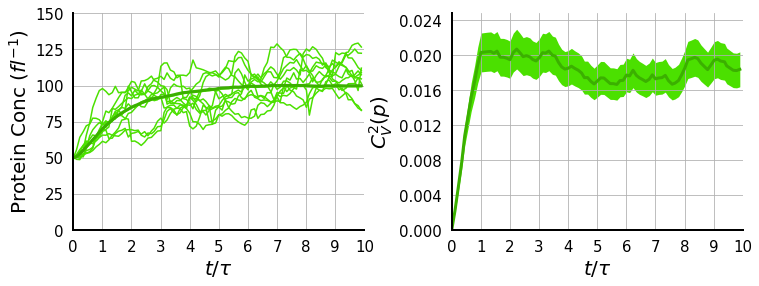

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

data=pd.read_csv("./data/prot_stat.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:10]:
    ax[0].plot(tt/doubling_time,data[column],c="#4BE000",label='_nolegend_')
    
ax[0].plot(tt/doubling_time,data.Mean_prot,c="#3BB000",lw=3)
ax[0].fill_between(tt/doubling_time,data.Mean_prot-data.Error_mean,data.Mean_prot+data.Error_mean,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[1].plot(tt/doubling_time,data.prot_CV2,c="#3BB000",lw=3)
ax[1].fill_between(tt/doubling_time,data.prot_CV2-data.Error_CV2,data.prot_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)


ax[0].set_ylabel("Protein Conc ($fl^{-1}$)",size=20)
ax[1].set_ylabel("$C_V^2(p)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
ax[0].set_ylim([0,1.5*np.max(data.Mean_prot)])
ax[1].set_ylim([0,1.2*np.max(data.prot_CV2)])
for l in [0,1]:
    ax[l].set_xlim([0,tmax/doubling_time])
    taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
taqui=np.arange(0,1.2*np.max(data.prot_CV2),step=np.round(.2*np.max(data.prot_CV2),3))
ax[1].set_yticks(np.array(taqui))

plt.savefig('./figures/prot_statistics.svg',bbox_inches='tight')
plt.savefig('./figures/prot_statistics.png',bbox_inches='tight')

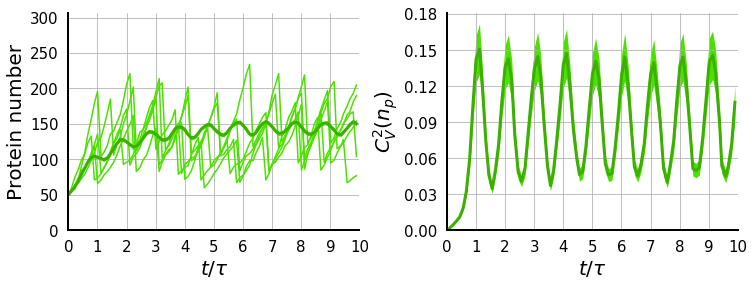

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

data=pd.read_csv("./data/nprot_stat.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:5]:
    ax[0].plot(tt/doubling_time,data[column],c="#4BE000",label='_nolegend_')
    
ax[0].plot(tt/doubling_time,data.Mean_prot,c="#3BB000",lw=3)
ax[0].fill_between(tt/doubling_time,data.Mean_prot-data.Error_mean,data.Mean_prot+data.Error_mean,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[1].plot(tt/doubling_time,data.prot_CV2,c="#3BB000",lw=3)
ax[1].fill_between(tt/doubling_time,data.prot_CV2-data.Error_CV2,data.prot_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)


ax[0].set_ylabel("Protein number",size=20)
ax[1].set_ylabel("$C_V^2(n_p)$",size=20)
ax[0].set_xlabel(r"$t/\tau$",size=20)
ax[1].set_xlabel(r"$t/\tau$",size=20)
ax[0].set_ylim([0,2*np.max(data.Mean_prot)])
ax[1].set_ylim([0,1.2*np.max(data.prot_CV2)])
for l in [0,1]:
    ax[l].set_xlim([0,tmax/doubling_time])
    taqui=np.arange(0,(tmax+1)/doubling_time,step=1)
    ax[l].set_xticks(np.array(taqui))
    ax[l].grid()
    ax[l].tick_params(axis='x', labelsize=15)
    ax[l].tick_params(axis='y', labelsize=15)
    for axis in ['bottom','left']:
        ax[l].spines[axis].set_linewidth(2)
        ax[l].tick_params(axis='both', width=2,length=6)
    for axis in ['top','right']:
        ax[l].spines[axis].set_linewidth(0)
        ax[l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
taqui=np.arange(0,1.2*np.max(data.prot_CV2),step=np.round(.2*np.max(data.prot_CV2),2))
ax[1].set_yticks(np.array(taqui))

plt.savefig('./figures/nprot_statistics.svg',bbox_inches='tight')
plt.savefig('./figures/nprot_statistics.png',bbox_inches='tight')

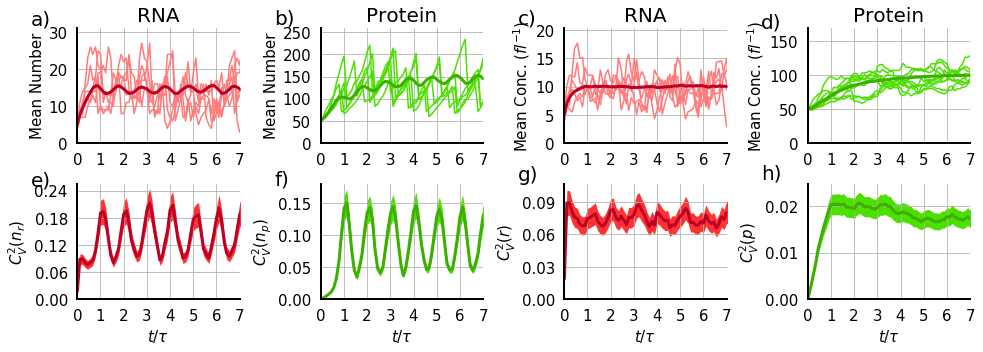

In [18]:
fig, ax = plt.subplots(2,4, figsize=(16,5))


data=pd.read_csv("./data/nRNAsim.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:5]:
    ax[0,0].plot(tt/doubling_time,data[column],c="#FF7B7B",label='_nolegend_')

data=pd.read_csv("./data/nRNAsim.csv")

ax[0,0].plot(tt/doubling_time,data.Mean_RNA,c="#BD0025",lw=3)
ax[0,0].fill_between(tt/doubling_time,data.Mean_RNA-data.Error_mean,data.Mean_RNA+data.Error_mean,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[1,0].plot(tt/doubling_time,data.RNA_CV2,c="#BD0025",lw=3)
ax[1,0].fill_between(tt/doubling_time,data.RNA_CV2-data.Error_CV2,data.RNA_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[0,0].set_ylim([0,2*np.max(data.Mean_RNA)])
ax[1,0].set_ylim([0,1.2*np.max(data.RNA_CV2)])

taqui=np.arange(0,2.1*np.max(data.Mean_RNA),step=np.round(10,0))
ax[0,0].set_yticks(np.array(taqui))
taqui=np.arange(0,1.2*np.max(data.RNA_CV2),step=np.round(.3*np.max(data.RNA_CV2),2))
ax[1,0].set_yticks(np.array(taqui))


data=pd.read_csv("./data/nprot_stat.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:5]:
    ax[0,1].plot(tt/doubling_time,data[column],c="#4BE000",label='_nolegend_')
    
ax[0,1].plot(tt/doubling_time,data.Mean_prot,c="#3BB000",lw=3)
ax[0,1].fill_between(tt/doubling_time,data.Mean_prot-data.Error_mean,data.Mean_prot+data.Error_mean,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[1,1].plot(tt/doubling_time,data.prot_CV2,c="#3BB000",lw=3)
ax[1,1].fill_between(tt/doubling_time,data.prot_CV2-data.Error_CV2,data.prot_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[0,1].set_ylim([0,1.7*np.max(data.Mean_prot)])
ax[1,1].set_ylim([0,1.2*np.max(data.prot_CV2)])
taqui=np.arange(0,1.8*np.max(data.Mean_prot),step=np.round(50,0))
ax[0,1].set_yticks(np.array(taqui))
taqui=np.arange(0,1.2*np.max(data.prot_CV2),step=np.round(.3*np.max(data.prot_CV2),2))
ax[1,1].set_yticks(np.array(taqui))


data=pd.read_csv("./data/cRNAsim.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:5]:
    ax[0,2].plot(tt/doubling_time,data[column],c="#FF7B7B",label='_nolegend_')
data=pd.read_csv("./data/cRNAsim.csv")
    
ax[0,2].plot(tt/doubling_time,data.Mean_RNA,c="#BD0025",lw=3)
ax[0,2].fill_between(tt/doubling_time,data.Mean_RNA-data.Error_mean,data.Mean_RNA+data.Error_mean,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[1,2].plot(tt/doubling_time,data.RNA_CV2,c="#BD0025",lw=3)
ax[1,2].fill_between(tt/doubling_time,data.RNA_CV2-data.Error_CV2,data.RNA_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#FF3333', facecolor='#FF3333',linewidth=0)
ax[0,2].set_ylim([0,2*np.max(data.Mean_RNA)])
ax[1,2].set_ylim([0,1.2*np.max(data.RNA_CV2)])
taqui=np.arange(0,2.1*np.max(data.Mean_RNA),step=np.round(.5*np.max(data.Mean_RNA),0))
ax[0,2].set_yticks(np.array(taqui))
taqui=np.arange(0,1.2*np.max(data.RNA_CV2),step=np.round(.3*np.max(data.RNA_CV2),2))
ax[1,2].set_yticks(np.array(taqui))


data=pd.read_csv("./data/prot_stat.csv")

tt=data.time
del data['time']
del data["Unnamed: 0"]
for column in data.columns[0:10]:
    ax[0,3].plot(tt/doubling_time,data[column],c="#4BE000",label='_nolegend_')
    
ax[0,3].plot(tt/doubling_time,data.Mean_prot,c="#3BB000",lw=3)
ax[0,3].fill_between(tt/doubling_time,data.Mean_prot-data.Error_mean,data.Mean_prot+data.Error_mean,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[1,3].plot(tt/doubling_time,data.prot_CV2,c="#3BB000",lw=3)
ax[1,3].fill_between(tt/doubling_time,data.prot_CV2-data.Error_CV2,data.prot_CV2+data.Error_CV2,
                 alpha=1, edgecolor='#4BE000', facecolor='#4BE000',linewidth=0)
ax[0,3].set_ylim([0,1.7*np.max(data.Mean_prot)])
ax[1,3].set_ylim([0,1.2*np.max(data.prot_CV2)])
taqui=np.arange(0,1.8*np.max(data.Mean_prot),step=np.round(50,0))
ax[0,3].set_yticks(np.array(taqui))
taqui=np.arange(0,1.2*np.max(data.prot_CV2),step=np.round(.3*np.max(data.prot_CV2),2))
ax[1,3].set_yticks(np.array(taqui))

for l in [0,1,2,3]:
    for m in [0,1]:
        ax[m,l].set_xlim([0,0.7*tmax/doubling_time])
        taqui=np.arange(0,0.8*tmax/doubling_time,step=1)
        ax[m,l].set_xticks(np.array(taqui))
        ax[m,l].grid()
        ax[m,l].tick_params(axis='x', labelsize=15)
        ax[m,l].tick_params(axis='y', labelsize=15)
        for axis in ['bottom','left']:
            ax[m,l].spines[axis].set_linewidth(2)
            ax[m,l].tick_params(axis='both', width=2,length=6)
        for axis in ['top','right']:
            ax[m,l].spines[axis].set_linewidth(0)
            ax[m,l].tick_params(axis='both', width=0,length=6)
plt.subplots_adjust(hspace=0.35,wspace=0.5)



ax[0,0].set_title("RNA",fontsize=20)
ax[0,1].set_title("Protein",fontsize=20)
ax[0,2].set_title("RNA",fontsize=20)
ax[0,3].set_title("Protein",fontsize=20)



ax[0,0].set_ylabel("Mean Number",size=15)
ax[1,0].set_ylabel("$C_V^2(n_r)$",size=15)
ax[0,1].set_ylabel("Mean Number",size=15)
ax[1,1].set_ylabel("$C_V^2(n_p)$",size=15)
ax[0,2].set_ylabel("Mean Conc. $(fl^{-1})$",size=15)
ax[1,2].set_ylabel("$C_V^2(r)$",size=15)
ax[0,3].set_ylabel("Mean Conc. $(fl^{-1})$",size=15)
ax[1,3].set_ylabel("$C_V^2(p)$",size=15)


ax[1,0].set_xlabel(r"$t/\tau$",size=15)
ax[1,1].set_xlabel(r"$t/\tau$",size=15)
ax[1,2].set_xlabel(r"$t/\tau$",size=15)
ax[1,3].set_xlabel(r"$t/\tau$",size=15)

ax[0,0].text(-2,32,"a)",fontsize=20)
ax[0,1].text(-2,270,"b)",fontsize=20)
ax[0,2].text(-2,21,"c)",fontsize=20)
ax[0,3].text(-2,170,"d)",fontsize=20)

ax[1,0].text(-2,0.25,"e)",fontsize=20)
ax[1,1].text(-2,0.18,"f)",fontsize=20)
ax[1,2].text(-2,0.11,"g)",fontsize=20)
ax[1,3].text(-2,0.026,"h)",fontsize=20)



plt.savefig('./figures/merge_statistics2.svg',bbox_inches='tight')
plt.savefig('./figures/merge_statistics2.png',bbox_inches='tight')
plt.savefig('./figures/merge_statistics2.eps',bbox_inches='tight')